## Part II
# Binomial Tree: option valuation (50 pts.)
 
 A commonly used approach to compute the price of an option is the so-called binomial tree method. Suppose that the maturity of an option on a non-dividend-paying stock St is divided into N subintervals of length ∆t. We will refer to the j th node at time i · ∆t as the (i, j) node. The stock price at the (i, j) node is Si,j = S0u^j * d^(i-j) (with u and d the upward and downward stock price movements, respectively). In the binomial tree approach, option prices are computed through a backward induction scheme:

1. The value of a call option at its expiration date is max{$0, S_{N,j} − K$};
2. Suppose that the values of the option at time (i + 1) · ∆t is known for all j. There is a risk-neutral probability p of moving from the (i, j) node at time i · ∆t to the (i + 1, j + 1) node at time (i + 1) · ∆t , and a probability 1 − p of moving from the (i, j) node at time i · ∆t to the (i + 1, j) node at time (i + 1) · ∆t . Risk-neutral valuation gives $f_{i,j} = e^{-r\Delta t} \left( p f_{i+1,j+1} + (1 - p) f_{i+1,j} \right)$

A general introduction to the binomial tree model and a detailed derivation of the relevant parameters is provided in appendix A. Please read the appendix carefully before starting on the assignment.

Consider a European call option on a non-dividend-paying stock with a maturity of one year and strike price of €99. Let the one year interest rate be 6% and the current price of the stock be €100. Furthermore, assume that the volatility is 20%.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm

C:\Users\Admin\AppData\Local\Temp\ipykernel_22036\1219111520.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def buildTree(S, vol, T, N):
    """
    Function to build the binomial tree

    Parameters
    ----------
    S : float
        Initial stock price
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the stock price at each node
    """
    dt = T / N

    matrix = np.zeros((N + 1, N + 1))

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))
    
    for i in np.arange(N + 1):
        for j in np.arange(i + 1):
            matrix[i, j] = S * (u ** j) * (d ** (i - j))
            
    return matrix

In [3]:
sigma = 0.1
S = 80
T = 1
N = 2
buildTree(S, sigma, T, N)

array([[80.        ,  0.        ,  0.        ],
       [74.53851387, 85.86165282,  0.        ],
       [69.44987563, 80.        , 92.15279281]])

In [10]:
def valueOptionMatrix(tree, vol, T, N, r, K):
    """
    Function to value an option using the binomial tree

    Parameters
    ----------
    tree : np.array
        Binomial tree, with the stock price at each node
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    r : float
        Risk-free rate
    K : float
        Strike price
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the option value at each node
    """
    tree = tree.copy()
    
    dt = T / N

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c] # value in the matrix
        tree[rows - 1, c] = max(S - K, 0) # payoff function
    
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            # print(f"r: {r}, dt: {dt}, p: {p}, down: {down}, up: {up}")
            tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)
            
    return tree

In [12]:
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
print(f"Tree: \n{tree}")
options = valueOptionMatrix(tree, sigma, T, N, r, K)
print(f"Options: \n{options}")

Tree: 
[[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]
Options: 
[[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]


## Question 1

In [6]:
sigma = 0.2
S = 100
T = 1
N = 50

K = 99
r = 0.06

tree = buildTree(S, sigma, T, N)
option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
option_price_binom = option_matrix[0, 0]

print(f"Option price: €{option_price_binom:.2f}")

Option price: €11.55


# Question 2

In [7]:
def option_price_analytical(S, T, r, K, sigma):
    # Black-Scholes formula for European option prices
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

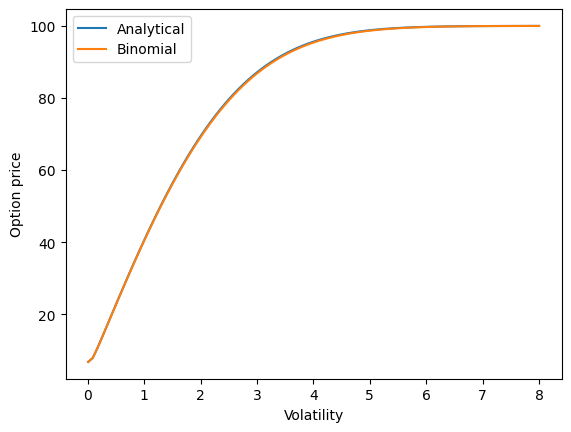

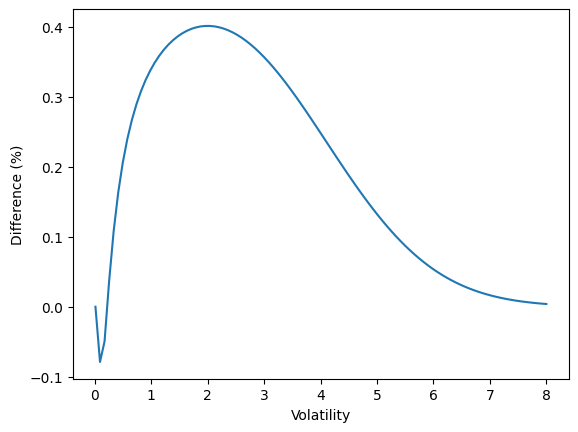

In [8]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

analytical_pricings = []
binomial_pricings = []

for sigma in sigma_values:
    option_price_analyt = option_price_analytical(S, T, r, K, sigma)
    tree = buildTree(S, sigma, T, N)
    option_matrix = valueOptionMatrix(tree, sigma, T, N, r, K)
    option_price_binom = option_matrix[0, 0]

    analytical_pricings.append(option_price_analyt)
    binomial_pricings.append(option_price_binom)

# Plot the results
plt.plot(sigma_values, analytical_pricings, label="Analytical")
plt.plot(sigma_values, binomial_pricings, label="Binomial")
plt.xlabel("Volatility")    
plt.ylabel("Option price")
plt.legend()
plt.show()

# Procentual difference
diff = (np.array(analytical_pricings) - np.array(binomial_pricings)) / np.array(analytical_pricings) * 100
plt.plot(sigma_values, diff)
plt.xlabel("Volatility")
plt.ylabel("Difference (%)")
plt.show()

## Question 3

 20%|██        | 61/299 [00:00<00:00, 599.42it/s]

100%|██████████| 299/299 [00:09<00:00, 31.71it/s] 


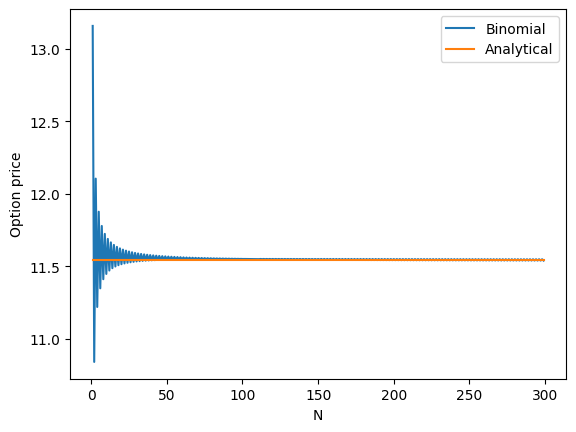

In [9]:
sigma = 0.2
S = 100
T = 1

K = 99
r = 0.06

# Play around with different ranges of N and step sizes.
N = np.arange(1, 300)

# Calculate the option price for the correct parameters
optionPriceAnalytical = option_price_analytical(S, T, r, K, sigma)

# Calculate option price for each n in N
optionPricesBinomial = []
for n in tqdm(N):
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly = valueOptionMatrix(treeN, sigma, T, n, r, K)[0, 0]
    optionPricesBinomial.append(priceApproximatedly)

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.plot(N, optionPricesBinomial, label="Binomial")
plt.plot(N, [optionPriceAnalytical] * len(N), label="Analytical")
plt.xlabel("N")
plt.ylabel("Option price")
plt.legend()
plt.show()

## Question 4

In [10]:
def delta_black_scholes(S, T, r, K, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

In [11]:
def delta_binomial(S, T, r, K, sigma, N):
    tree = buildTree(S, sigma, T, N)
    option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
    delta = (option_tree[1, 1] - option_tree[1, 0]) / (tree[1, 1] - tree[1, 0])
    return delta

In [12]:
# Test on small example
sigma = 0.1
S = 80
T = 1
N = 2

K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
print(f"Tree:\n {tree}\n")
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K)
print(f"Option Tree:\n {option_tree}\n")

delta_bs = delta_black_scholes(S, T, r, K, sigma)
delta_bin = delta_binomial(S, T, r, K, sigma, N)

print(f"Delta Black-Scholes: {delta_bs:.2f}")
print(f"Delta Binomial: {delta_bin:.2f}")

Tree:
 [[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]

Option Tree:
 [[4.61654023 0.         0.        ]
 [0.         5.74640373 0.        ]
 [0.         0.         7.15279281]]

Delta Black-Scholes: 0.67
Delta Binomial: 0.51


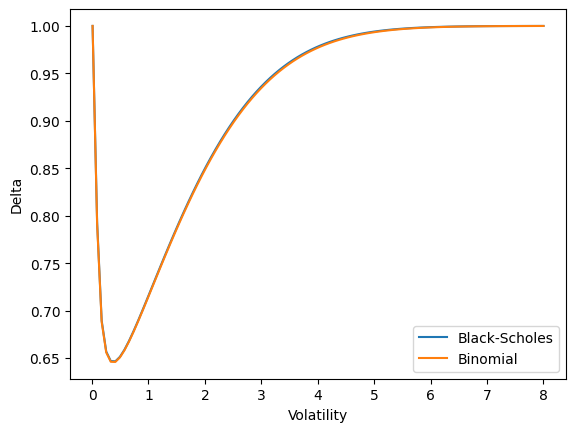

In [13]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

delta_bs_values = []
delta_bin_values = []

for sigma in sigma_values:
    delta_bs = delta_black_scholes(S, T, r, K, sigma)
    delta_bin = delta_binomial(S, T, r, K, sigma, N)

    delta_bs_values.append(delta_bs)
    delta_bin_values.append(delta_bin)

# Plot the results
plt.plot(sigma_values, delta_bs_values, label="Black-Scholes")
plt.plot(sigma_values, delta_bin_values, label="Binomial")
plt.xlabel("Volatility")
plt.ylabel("Delta")
plt.legend()
plt.show()

## Question 5

In [85]:
# Changed function to include american option, default is european
def valueOptionMatrix(tree, vol, T, N, r, K, call=True, american=False):
    """
    Function to value an option using the binomial tree

    Parameters
    ----------
    tree : np.array
        Binomial tree, with the stock price at each node
    vol : float
        Volatility of the stock
    T : float
        Time to maturity
    N : int
        Number of steps in the tree
    r : float
        Risk-free rate
    K : float
        Strike price
    call : bool
        If the option is a call or a put (False means put option)
    american : bool
        If the option is american or european
    
    Returns
    -------
    matrix : np.array
        Binomial tree, with the option value at each node
    """
    tree = tree.copy()
    
    dt = T / N

    u = np.exp(vol * np.sqrt(dt))
    d = np.exp(-vol * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    # print(f"Up: {u}, Down: {d}, p: {p}")

    columns = tree.shape[1]
    rows = tree.shape[0]
    
    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c] # value in the matrix
        if call:
            tree[rows - 1, c] = max(S - K, 0)
        else:
            tree[rows - 1, c] = max(K - S, 0)
    
    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            
            exercise_now_value = tree[i, j] - K if call else K - tree[i, j]

            # If american option, we need to check if it is better to exercise
            if american:
                tree[i, j] = max(np.exp(-r * dt) * (p * up + (1 - p) * down), exercise_now_value)
            else:
                tree[i, j] = np.exp(-r * dt) * (p * up + (1 - p) * down)
            
    return tree

In [86]:
# Example from second to last slide from BINOMIAL-MODEL.pdf lecture
sigma = 0.4
S = 50
T = 5/12.0
N = 5

K = 50
r = 0.1

tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)

# Round to 2 decimals
tree = np.round(tree, 2)
option_tree = np.round(option_tree, 2)
option_tree_american = np.round(option_tree_american, 2)

print(f"Tree:\n {tree}\n")
print(f"Option Tree:\n {option_tree}\n")
print(f"Option Tree American:\n {option_tree_american}\n")

# Check if any value differs
print(f"Both option trees the same? {np.all(option_tree == option_tree_american)}")



Tree:
 [[50.    0.    0.    0.    0.    0.  ]
 [44.55 56.12  0.    0.    0.    0.  ]
 [39.69 50.   62.99  0.    0.    0.  ]
 [35.36 44.55 56.12 70.7   0.    0.  ]
 [31.5  39.69 50.   62.99 79.35  0.  ]
 [28.07 35.36 44.55 56.12 70.7  89.07]]

Option Tree:
 [[ 4.32  0.    0.    0.    0.    0.  ]
 [ 6.66  2.11  0.    0.    0.    0.  ]
 [ 9.86  3.67  0.64  0.    0.    0.  ]
 [13.81  6.18  1.3   0.    0.    0.  ]
 [18.08  9.9   2.66  0.    0.    0.  ]
 [21.93 14.64  5.45  0.    0.    0.  ]]

Option Tree American:
 [[ 4.49  0.    0.    0.    0.    0.  ]
 [ 6.96  2.16  0.    0.    0.    0.  ]
 [10.36  3.77  0.64  0.    0.    0.  ]
 [14.64  6.38  1.3   0.    0.    0.  ]
 [18.5  10.31  2.66  0.    0.    0.  ]
 [21.93 14.64  5.45  0.    0.    0.  ]]

Both option trees the same? False


In [88]:
# Parameters as given in part 2

sigma = 0.2
S = 100
T = 1
N = 50

K = 99
r = 0.06

# First as a call
tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)

option_price_european = option_tree[0, 0]
option_price_american = option_tree_american[0, 0]

print(f"Call option price (European): €{option_price_european:.2f}")
print(f"Call option price (American): €{option_price_american:.2f}\n")

# Then as a put
tree = buildTree(S, sigma, T, N)
option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)

option_price_european = option_tree[0, 0]
option_price_american = option_tree_american[0, 0]

print(f"Put option price (European): €{option_price_european:.2f}")
print(f"Put option price (American): €{option_price_american:.2f}\n")

Call option price (European): €11.55
Call option price (American): €11.55

Put option price (European): €4.78
Put option price (American): €5.35



In [99]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 8, 100)

call_prices_european = []
call_prices_american = []
put_prices_european = []
put_prices_american = []

for sigma in sigma_values:
    tree = buildTree(S, sigma, T, N)
    call_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
    call_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)
    call_prices_european.append(call_option_tree[0, 0])
    call_prices_american.append(call_option_tree_american[0, 0])

    put_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
    put_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)
    put_prices_european.append(put_option_tree[0, 0])
    put_prices_american.append(put_option_tree_american[0, 0])

df = pd.DataFrame({
    "sigma": sigma_values,
    "sigma_percentages": sigma_values * 100, # For plotting purposes
    "call_prices_european": call_prices_european,
    "call_prices_american": call_prices_american,
    "put_prices_european": put_prices_european,
    "put_prices_american": put_prices_american
})

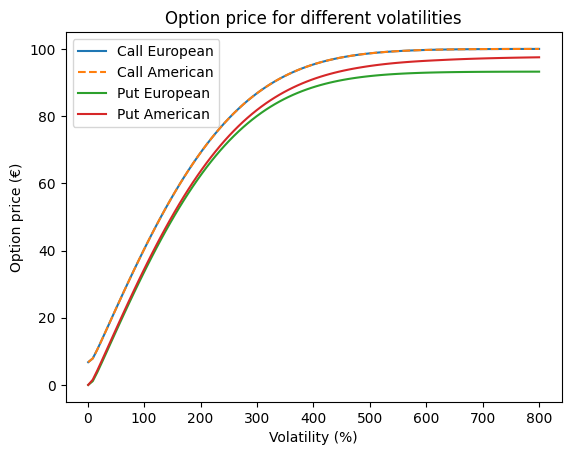

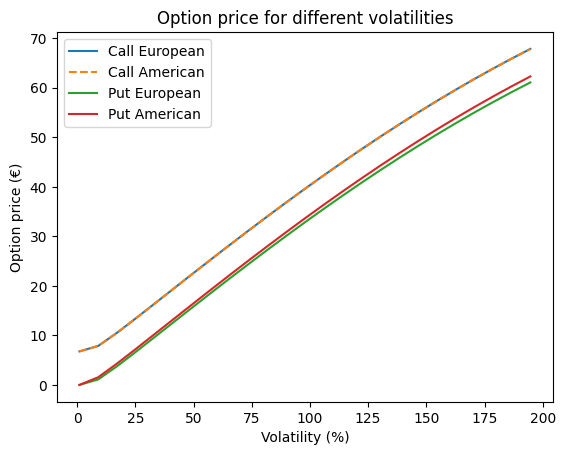

In [102]:
# Plot the results
plt.plot(df["sigma_percentages"], df["call_prices_european"], label="Call European")
plt.plot(df["sigma_percentages"], df["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df["sigma_percentages"], df["put_prices_european"], label="Put European")
plt.plot(df["sigma_percentages"], df["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()

# Plot only until 100% volatility
df_low_end = df[df["sigma_percentages"] <= 200]
plt.plot(df_low_end["sigma_percentages"], df_low_end["call_prices_european"], label="Call European")
plt.plot(df_low_end["sigma_percentages"], df_low_end["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df_low_end["sigma_percentages"], df_low_end["put_prices_european"], label="Put European")
plt.plot(df_low_end["sigma_percentages"], df_low_end["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()

In [104]:
S = 100
T = 1
N = 50

K = 99
r = 0.06

sigma_values = np.linspace(0.01, 1, 100)

call_prices_european = []
call_prices_american = []
put_prices_european = []
put_prices_american = []

for sigma in sigma_values:
    tree = buildTree(S, sigma, T, N)
    call_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=False)
    call_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=True, american=True)
    call_prices_european.append(call_option_tree[0, 0])
    call_prices_american.append(call_option_tree_american[0, 0])

    put_option_tree = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=False)
    put_option_tree_american = valueOptionMatrix(tree, sigma, T, N, r, K, call=False, american=True)
    put_prices_european.append(put_option_tree[0, 0])
    put_prices_american.append(put_option_tree_american[0, 0])

df_detailed = pd.DataFrame({
    "sigma": sigma_values,
    "sigma_percentages": sigma_values * 100, # For plotting purposes
    "call_prices_european": call_prices_european,
    "call_prices_american": call_prices_american,
    "put_prices_european": put_prices_european,
    "put_prices_american": put_prices_american
})

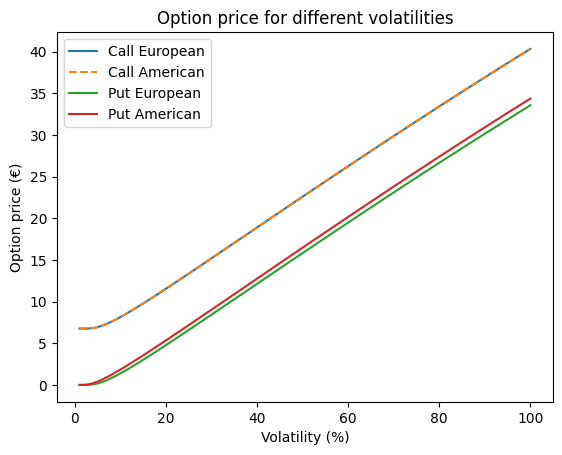

In [105]:
# Plot the results
plt.plot(df_detailed["sigma_percentages"], df_detailed["call_prices_european"], label="Call European")
plt.plot(df_detailed["sigma_percentages"], df_detailed["call_prices_american"], label="Call American", linestyle="--")
plt.plot(df_detailed["sigma_percentages"], df_detailed["put_prices_european"], label="Put European")
plt.plot(df_detailed["sigma_percentages"], df_detailed["put_prices_american"], label="Put American")
plt.xlabel("Volatility (%)")
plt.ylabel("Option price (€)")
plt.title("Option price for different volatilities")
plt.legend()
plt.show()